<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
$\beta\beta0\nu$ Reconstruction Analysis True Hits (RATH) </p><br>

## This notebook
- Run the reconstruction analysis for True hits (RATH).
    - The RATH voxelises MC True Hits, then computes TrackGraphs and find voxels extremes.
    - The driver returns object containing relevant statistics and a EventTrack object, that is, a list, indexed by event number of GTRacks.
- Saves and loads from disk
    - This documents the use of functions that can be used to save and load the output of a RATH run. 
- Plot Statistics
- GraphTracks manipulation
    - GraphTracks are constructed from the EventTrack object, and are used to define blobs and find blob energy. 
- Visualisation of events where single and multiple tracks where reconstructed in $\beta\beta0\nu$ events.

In [2]:
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### General

In [3]:
# General importings
import os
import sys
import glob
import logging
import math
import numpy  as np
import warnings
import functools
import time

from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D 
import networkx as nx
from itertools   import combinations

In [4]:
from pandas import DataFrame, Series
from typing import List, Tuple
from typing import Union
from   dataclasses import dataclass

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
plt.rcParams["figure.figsize"] = 8, 6
plt.rcParams["font.size"     ] = 14

#### IC

In [8]:

import invisible_cities.core.system_of_units  as units

from invisible_cities.io.mcinfo_io import load_mcconfiguration
from invisible_cities.io.mcinfo_io import load_mcparticles_df
from invisible_cities.io.mcinfo_io import load_mchits_df
from invisible_cities.io.mcinfo_io import load_mcsensor_positions
from invisible_cities.io.mcinfo_io import load_mcsensor_response_df
from invisible_cities.io.mcinfo_io import get_sensor_types
from invisible_cities.io.mcinfo_io import get_sensor_binning
from invisible_cities.io.mcinfo_io import get_event_numbers_in_file
from invisible_cities.core.core_functions import in_range


#### TICs

In [9]:
from tics.histograms    import h1
from tics.pd_tics       import get_index_slice_from_multi_index
from tics.pd_tics   import slice_and_select_df
from tics.graphics_reco import plot_hits3d
from tics.stats_tics    import bin_data_with_equal_bin_size
from tics.util_tics import get_class_name
from tics.util_tics import Range
from tics.graphics_reco import plot_gtrack
from tics.graphics_reco import plot_gtracks
from tics.system_of_units import *

#### NetFlex

In [10]:
from nextflex.core import Setup

In [11]:
from nextflex.core import Setup
from nextflex.mctrue_functions import get_mc_particles
from nextflex.mctrue_functions import get_mc_primary_particles
from nextflex.mctrue_functions import get_mc_vertex
from nextflex.mctrue_functions import select_mc_particles
from nextflex.mctrue_functions import get_mc_hits
from nextflex.mctrue_functions import select_mc_hits
from nextflex.mctrue_functions import total_hit_energy
from nextflex.mctrue_functions import get_event_hits_from_mchits

In [153]:
from nextflex.reco_functions import voxelize_hits
from nextflex.reco_functions import get_voxels_as_list
from nextflex.reco_functions import voxel_position
from nextflex.reco_functions import voxel_energy
from nextflex.reco_functions import voxel_nhits
from nextflex.reco_functions import distance_between_two_voxels
from nextflex.reco_functions import voxel_distances
from nextflex.reco_functions import voxel_distance_pairs
from nextflex.reco_functions import make_track_graphs
from nextflex.reco_functions import gtrack_voxels
from nextflex.reco_functions import shortest_paths
from nextflex.reco_functions import find_extrema_and_length
from nextflex.reco_functions import GTrack
from nextflex.reco_functions import voxels_in_blob
from nextflex.reco_functions import blob_energy
from nextflex.reco_functions import write_gtracks_json
from nextflex.reco_functions import load_gtracks_json
from nextflex.reco_functions import write_event_gtracks_json
from nextflex.reco_functions import load_event_gtracks_json

In [150]:
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack
from nextflex.reco_analysis import reco_gtrack_blobs
from nextflex.reco_analysis import TrackRecoStats
from nextflex.reco_analysis import TrackRecoTiming
from nextflex.reco_analysis import TrackRecoEventStats
from nextflex.reco_analysis import save_to_JSON
from nextflex.reco_analysis import load_from_JSON
from nextflex.reco_analysis import TrackRecoAnalysisSetup
from nextflex.reco_analysis import GtrkStats
from nextflex.reco_analysis import gtrack_summary
from nextflex.reco_analysis import select_gtrack_topology
from nextflex.reco_analysis import distance_between_extrema
from nextflex.reco_analysis import gtrack_df
from nextflex.reco_analysis import event_list_by_multiplicity


In [134]:
from nextflex.analysis_histos import reco_gtrack_stats_histos
from nextflex.analysis_histos import reco_gtrack_timing_histos
from nextflex.analysis_histos import reco_gtrack_blobs_histos
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

### Input data

In [14]:
FDATA = os.environ['FLEXDATA']

In [15]:
setup = Setup(flexDATA = FDATA,
              sipmPDE  = 1.0,
              maskPDE  = 1.0,
              qTh      = 0.0,
              tpConfig = "FLEX100_M6_O6_EL8bar_bb0nu")
print(setup)


        Setup <FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0>:
        tracking plane configuration = FLEX100_M6_O6_EL8bar_bb0nu
        sipm PDE                     = 1.0
        transmission of teflon masks = 1.0
        charge threshold             = 0.0
        energy sensors               = PMTs
        pitch                        = 15.55
        number of energy sensors     = 60
        number of SiPMs              = 3093
        root directory               = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu
        analysis directory           = /Users/jj/Development/flexdata/analysis/FLEX100_M6_O6_EL8bar_bb0nu
        number of h5 files in dir    = 208
        sipm map at                  = /Users/jj/Development/flexdata/flexmaps/sipm_map_15.6_mm.csv
        sipm map name                = sipm_map_15.6_mm.csv
        output file                  = /Users/jj/Development/flexdata/kdsts/FLEX100_M6_O6_EL8bar_bb0nu_PMTs_sipmPDE_1.0_maskPDE_1.0_qTh_0.0.cs

In [105]:
ifnames = glob.glob(f"{FDATA}/{setup.tpConfig}/*.h5")
print(f'found {len(ifnames)} files')

found 206 files


### Run with large voxels

In [108]:
voxel_bin  = 3
rb         = 5
contiguity = 6

In [109]:
gtEvent, trackRecoStats, trackRecoEventStats, trackRecoTiming = reco_gtrack(ifnames, 
                                                                          voxel_bin, 
                                                                          contiguity,
                                                                          debug=False,
                                                                           ic = 1)

file number = 1, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5
file number = 2, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.43.next.h5
file number = 3, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.123.next.h5
file number = 4, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.245.next.h5
file number = 5, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.88.next.h5
file number = 6, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.98.next.h5
file number = 7, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.237.next.h5
file number = 8, name=/Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.227.next.h5
file

#### 1 track efficiency

In [111]:
print(f"bb0nu efficiency = {trackRecoEventStats.e_gt/trackRecoEventStats.e_total}")

bb0nu efficiency = 0.5995115995115995


### Save to disk

In [144]:
traSetup = TrackRecoAnalysisSetup(setup, voxel_bin, contiguity, gtEvent,
                                 trackRecoStats, trackRecoEventStats, trackRecoTiming)

In [145]:
save_to_JSON(traSetup.trackRecoStats, traSetup.fileTrackRecoStats, numpy_convert=True)

In [146]:
save_to_JSON(traSetup.trackRecoTiming, traSetup.fileTrackRecoTiming, numpy_convert=True)

In [147]:
save_to_JSON(traSetup.trackRecoEventStats, traSetup.fileTrackRecoEventStats, numpy_convert=False)

In [152]:
write_event_gtracks_json(gtEvent, traSetup.fileGTracks)

### Load from disk

In [154]:
trs  = TrackRecoStats(**load_from_JSON(traSetup.fileTrackRecoStats))

In [155]:
trt  = TrackRecoTiming(**load_from_JSON(traSetup.fileTrackRecoTiming))

In [156]:
tres = TrackRecoEventStats(**load_from_JSON(traSetup.fileTrackRecoEventStats))

In [157]:
gte  = load_event_gtracks_json(traSetup.fileGTracks)

### Statistics 

#### Run statistics for RecoEvent, first from memory, then from disk 

In [158]:
trackRecoEventStats


        <Track Reconstruction Statistics>
        first file analyzed        = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5
        number of files analyzed   = 206
        size of voxel bins         = 3
        contiguity parameter       = 6
        Number of events analyized = 819
        Number of events 1 GT      = 491
        

In [159]:
tres


        <Track Reconstruction Statistics>
        first file analyzed        = /Users/jj/Development/flexdata/FLEX100_M6_O6_EL8bar_bb0nu/FLEX100_M6_O6.Xe136_bb0nu.ACTIVE.53.next.h5
        number of files analyzed   = 206
        size of voxel bins         = 3
        contiguity parameter       = 6
        Number of events analyized = 819
        Number of events 1 GT      = 491
        

#### Track reconstruction statistics

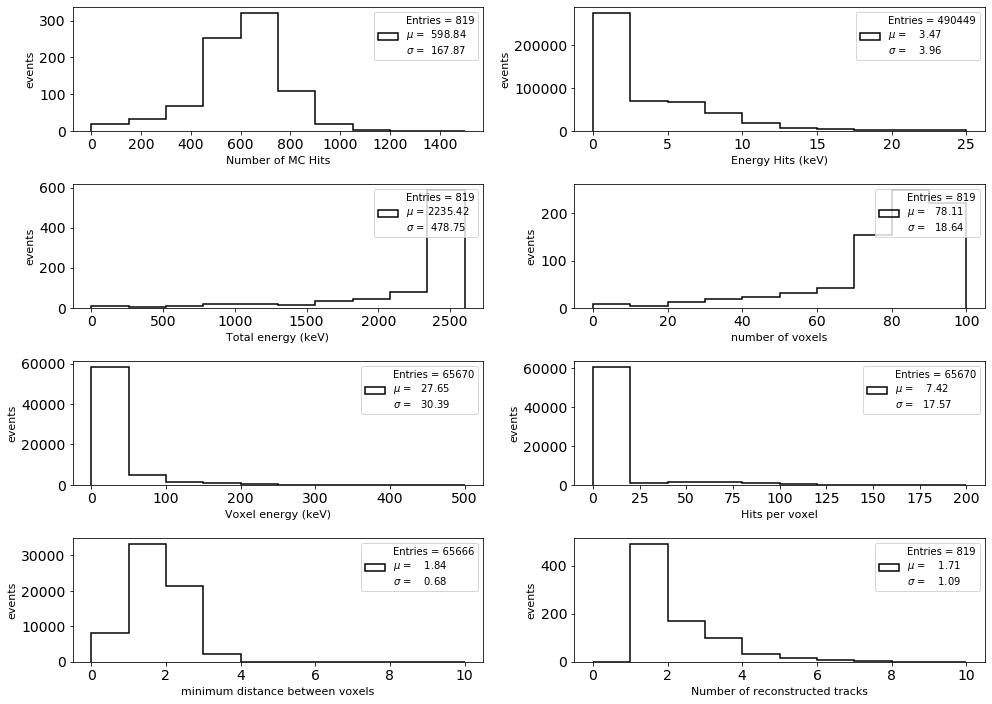

In [113]:
reco_gtrack_stats_histos(trackRecoStats, figsize=(14,10))

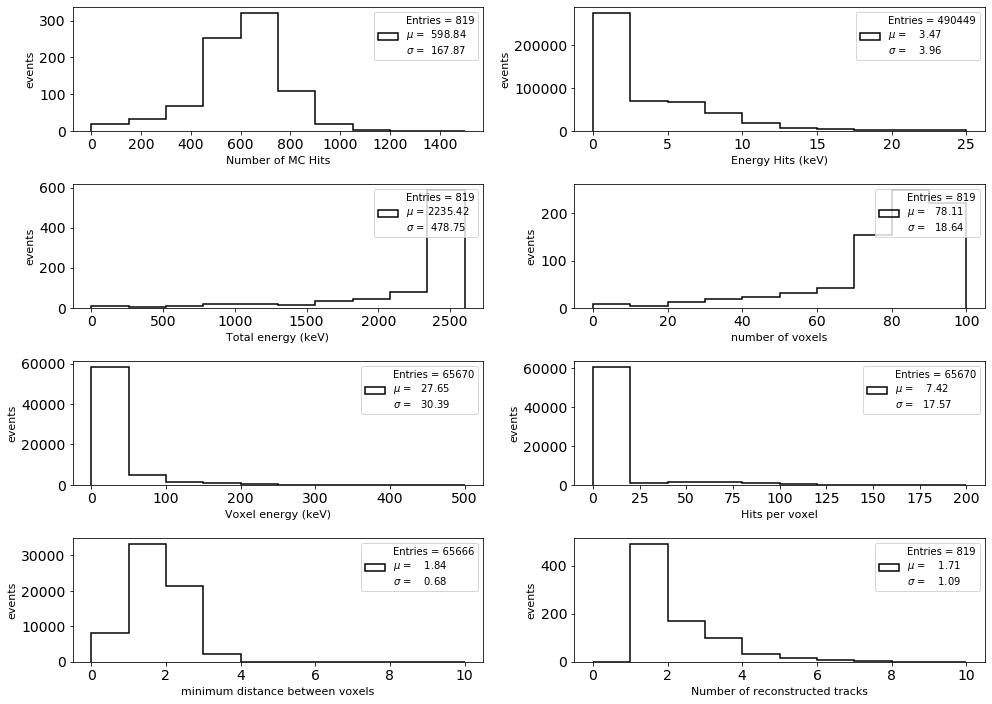

In [160]:
reco_gtrack_stats_histos(trs, figsize=(14,10))

#### Track reconstruction time

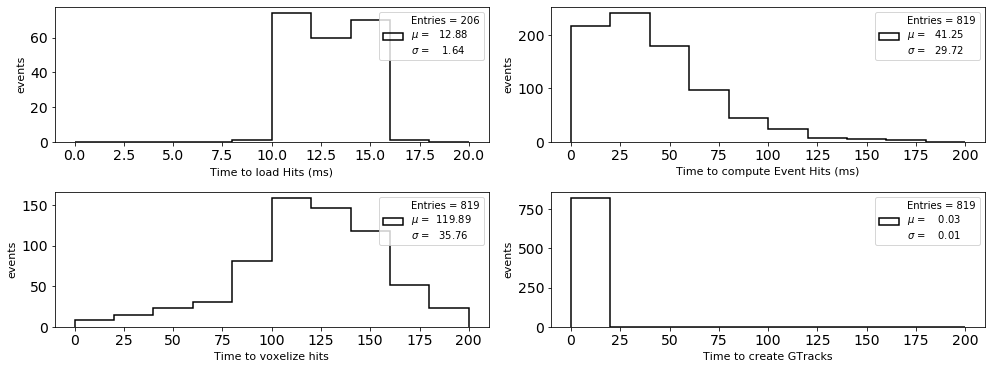

In [114]:
reco_gtrack_timing_histos(trackRecoTiming, figsize=(14,10))

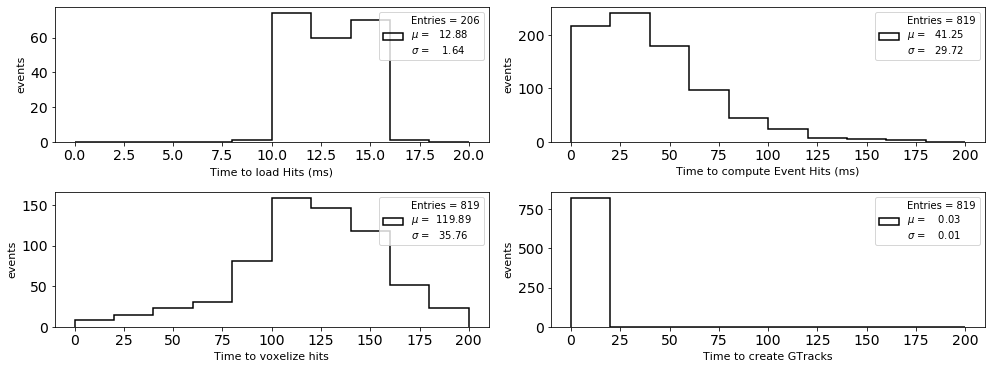

In [161]:
reco_gtrack_timing_histos(trt, figsize=(14,10))

### Compute the graphTracks for this run. 
- The resulting GraphTracks obect is indexed by event_number and trk_number. Each track includes an id corresponding to the event_id (Monte Carlo or reconstructed event number) and a unique identifier that links with the GTrack object (in case we want to recover the full list of voxels)

In [115]:
graphTracks = gtrack_df(gtEvent, rb)

In [116]:
gtdf = graphTracks.df
gtdf

gtrack_uid  event_id  nvox  \
evt_number trk_number                                                         
0          0           1f19fc12-510c-11eb-b267-10ddb1bc7534       212    74   
           1           1f1e6c3e-510c-11eb-b267-10ddb1bc7534       212     1   
           2           1f1e954c-510c-11eb-b267-10ddb1bc7534       212     1   
           3           1f1eb6d0-510c-11eb-b267-10ddb1bc7534       212     1   
1          0           1f86d9f4-510c-11eb-b267-10ddb1bc7534       213   101   
...                                                     ...       ...   ...   
816        0           5801fb36-510e-11eb-b267-10ddb1bc7534       137    85   
817        0           58491142-510e-11eb-b267-10ddb1bc7534       138    76   
818        0           58987570-510e-11eb-b267-10ddb1bc7534       139    55   
           1           589b28e2-510e-11eb-b267-10ddb1bc7534       139     1   
           2           589b4e30-510e-11eb-b267-10ddb1bc7534       139     1   

                          tlength        x_e1        y_e1        z_e1  \
evt_number trk_number                                                   
0          0           143.015494 -161.949594 -410.385351  799.373758   
           1             0.000000 -154.306005 -210.879696  907.142098   
           2             0.000000 -110.534864 -155.678515  899.274488   
           3             0.000000 -107.638045 -171.495649  902.835057   
1          0           148.713114 -242.607050  283.114841  717.288163   
...                           ...         ...         ...         ...   
816        0           104.879679  131.697544  -94.908838  851.737474   
817        0           134.525339  377.869179 -111.139625  591.595563   
818        0            49.449896    7.870709 -302.963190  243.866397   
           1             0.000000  133.591098 -341.463246  201.844479   
           2             0.000000  137.610421 -300.376597  171.923207   

                       energy_e1  nvox_b1   energy_b1        x_e2        y_e2  \
evt_number trk_number                                                           
0          0            0.200400        3  265.751667 -113.000488 -435.739631   
           1            0.012581        1   12.581009 -154.306005 -210.879696   
           2            0.029781        1   29.781301 -110.534864 -155.678515   
           3            0.132281        1  132.281467 -107.638045 -171.495649   
1          0            0.019515        4   80.674876 -227.332418  279.148276   
...                          ...      ...         ...         ...         ...   
816        0            0.212933        3  274.054753  178.414379 -137.187561   
817        0            0.018446        4  243.659247  419.254027 -120.291330   
818        0            0.012409        4   95.932051   23.239846 -333.042971   
           1            0.075744        1   75.744495  133.591098 -341.463246   
           2            0.029653        1   29.652908  137.610421 -300.376597   

                             z_e2  energy_e2  nvox_b2   energy_b2  
evt_number trk_number                                              
0          0           785.449729   0.048482        5  349.496331  
           1           907.142098   0.012581        1   12.581009  
           2           899.274488   0.029781        1   29.781301  
           3           902.835057   0.132281        1  132.281467  
1          0           648.756153   0.036894        4  253.510311  
...                           ...        ...      ...         ...  
816        0           837.197325   0.006908        3  214.421978  
817        0           640.178871   0.236683        3  274.565952  
818        0           228.599434   0.024795        3  306.179082  
           1           201.844479   0.075744        1   75.744495  
           2           171.923207   0.029653        1   29.652908  

[1401 rows x 16 columns]

In [162]:
gT = gtrack_df(gte, rb)

In [164]:
gT.df

,,gtrack_uid,event_id,nvox,tlength,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,trk_number,,,,,,,,,,,,,,,,
0,0,eab0445e-51b5-11eb-b267-10ddb1bc7534,212,1,0.000000,-107.638045,-171.495649,902.835057,0.132281,1,132.281467,-107.638045,-171.495649,902.835057,0.132281,1,132.281467
1,0,eab0a62e-51b5-11eb-b267-10ddb1bc7534,213,101,148.713114,-242.607050,283.114841,717.288163,0.019515,4,80.674876,-227.332418,279.148276,648.756153,0.036894,4,253.510311
2,0,eab8ca52-51b5-11eb-b267-10ddb1bc7534,214,111,155.672443,-140.766008,-68.545678,103.010861,0.143007,7,563.045194,-115.742150,-47.035269,63.866110,0.065382,2,83.126478
3,0,eac234fc-51b5-11eb-b267-10ddb1bc7534,215,94,92.530227,-362.447155,-288.698550,1079.363537,0.025789,6,122.912696,-328.159590,-318.074410,1062.269043,0.024581,5,79.741530
4,0,eacb41f0-51b5-11eb-b267-10ddb1bc7534,172,1,0.000000,-164.813389,-337.982025,562.033807,0.050828,1,50.827529,-164.813389,-337.982025,562.033807,0.050828,1,50.827529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
814,0,f802c794-51b5-11eb-b267-10ddb1bc7534,99,1,0.000000,300.364476,272.428880,823.301666,0.028916,1,28.915660,300.364476,272.428880,823.301666,0.028916,1,28.915660
815,0,f802ee04-51b5-11eb-b267-10ddb1bc7534,136,1,0.000000,-72.827209,457.925997,1019.189027,0.127304,1,127.304271,-72.827209,457.925997,1019.189027,0.127304,1,127.304271
816,0,f8033b34-51b5-11eb-b267-10ddb1bc7534,137,85,104.879679,131.697544,-94.908838,851.737474,0.212933,3,274.054753,178.414379,-137.187561,837.197325,0.006908,3,214.421978


#### Extract a list of event single tracks (est) and events multiple tracks (emt)

In [117]:
est, emt = event_list_by_multiplicity(graphTracks)

In [118]:
Verbose = False   # set to true if you want to see the lists
if Verbose:
    print(f'events single track (est) = {est}')
    print(f'\n events multiple track (ems) = {emt}')

#### Hitogram the GraphTracks variables

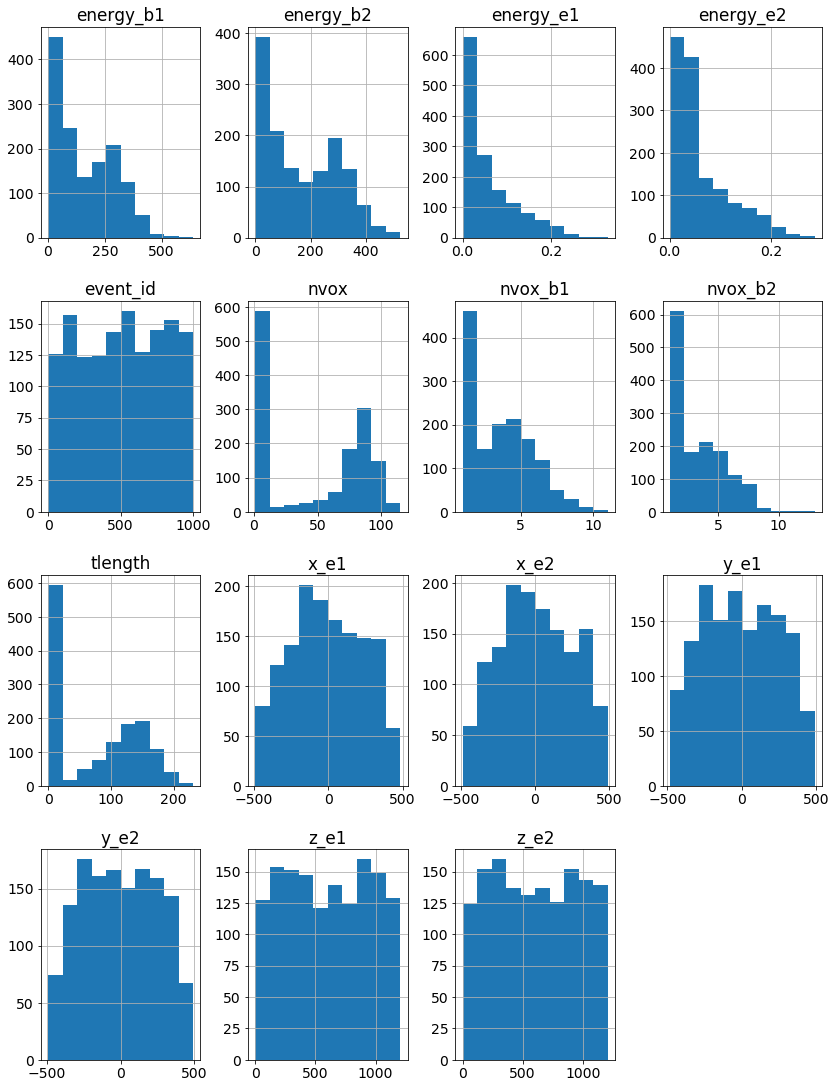

In [119]:
hist = gtdf.hist(bins=10, figsize = (14,19))

#### Select the topology of single tracks

In [120]:
g1tdf = select_gtrack_topology(graphTracks, topology = "single")

In [121]:
g1tdf

,,gtrack_uid,event_id,nvox,tlength,x_e1,y_e1,z_e1,energy_e1,nvox_b1,energy_b1,x_e2,y_e2,z_e2,energy_e2,nvox_b2,energy_b2
evt_number,trk_number,,,,,,,,,,,,,,,,
1,0,1f86d9f4-510c-11eb-b267-10ddb1bc7534,213,101,148.713114,-242.607050,283.114841,717.288163,0.019515,4,80.674876,-227.332418,279.148276,648.756153,0.036894,4,253.510311
2,0,200b8f50-510c-11eb-b267-10ddb1bc7534,214,111,155.672443,-140.766008,-68.545678,103.010861,0.143007,7,563.045194,-115.742150,-47.035269,63.866110,0.065382,2,83.126478
3,0,206ee4e2-510c-11eb-b267-10ddb1bc7534,215,94,92.530227,-362.447155,-288.698550,1079.363537,0.025789,6,122.912696,-328.159590,-318.074410,1062.269043,0.024581,5,79.741530
5,0,217f4aac-510c-11eb-b267-10ddb1bc7534,173,87,148.690831,167.906357,102.100815,536.493347,0.015820,6,353.963872,175.051533,158.683869,475.397794,0.016956,4,272.290754
6,0,21d5c300-510c-11eb-b267-10ddb1bc7534,174,89,147.261380,152.646709,120.526286,733.278140,0.114876,2,155.780979,241.219154,142.040817,724.793842,0.095880,9,253.138913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,0,14f07a3e-510e-11eb-b267-10ddb1bc7534,618,82,113.718405,383.628790,134.830867,335.933137,0.016666,6,129.373465,408.161825,109.679576,350.885373,0.110857,5,328.287650
806,0,1563267e-510e-11eb-b267-10ddb1bc7534,619,106,187.941580,145.120820,-430.574790,102.381087,0.081961,4,254.372529,169.768167,-406.262093,45.357146,0.069707,7,329.614348
810,0,1824548c-510e-11eb-b267-10ddb1bc7534,931,99,145.720779,436.777167,146.864276,427.622513,0.004307,5,412.420953,452.331282,130.899217,406.566962,0.040238,4,152.384756


#### And represent hitograms

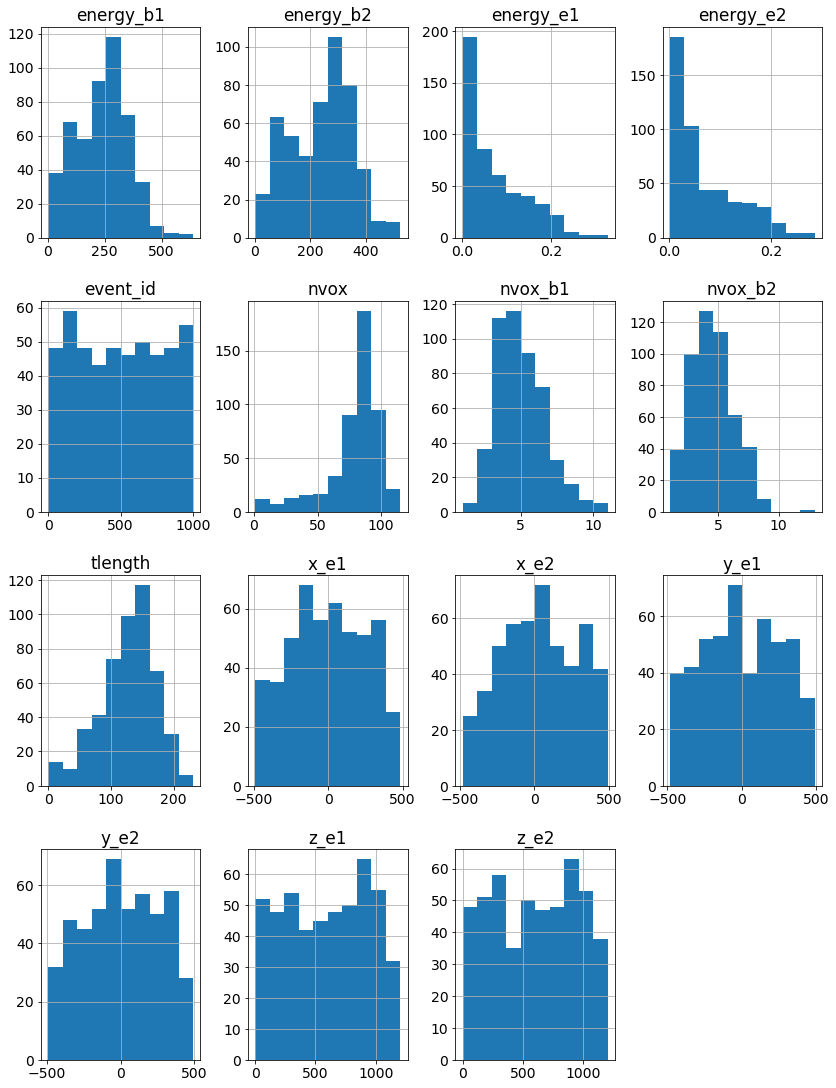

In [122]:
hist = g1tdf.hist(figsize = (14,19))

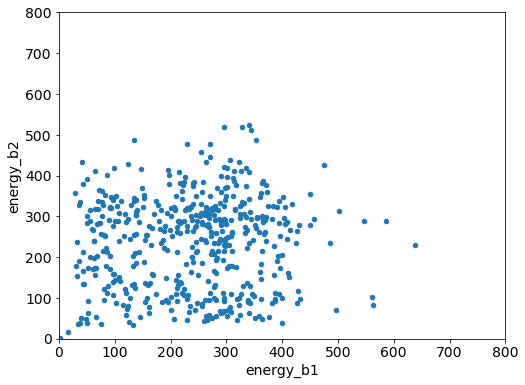

In [123]:
ax1 = g1tdf.plot.scatter(x='energy_b1', y='energy_b2')
ax1.set_xlim([0,800])
ax1.set_ylim([0,800])
plt.show()

#### Compute the distance between floating satelites extrema and main track extrema

In [124]:
deMT = distance_between_extrema(gmtdf)

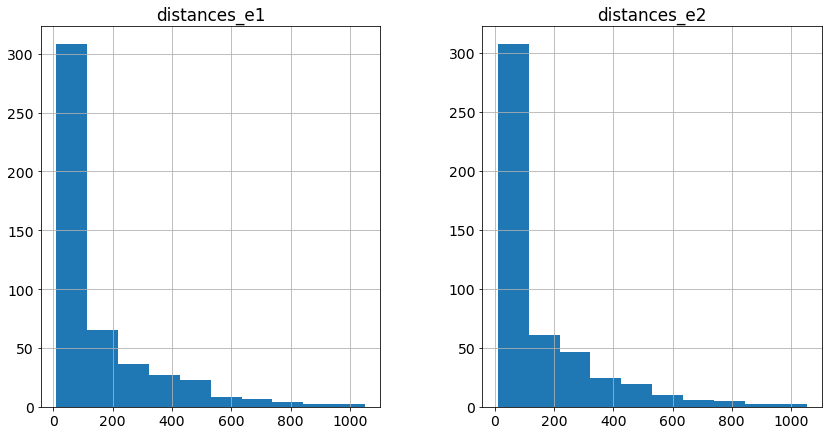

In [125]:
hist = deMT.hist(figsize = (14,7))

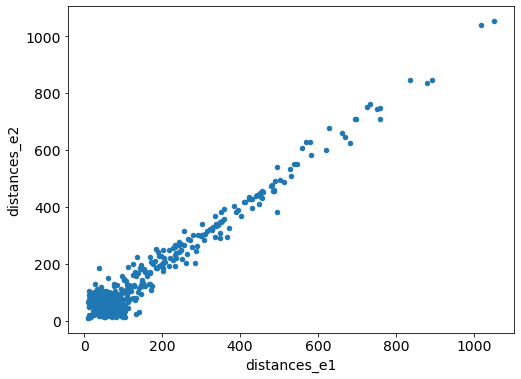

In [126]:
ax1 = deMT.plot.scatter(x='distances_e1', y='distances_e2')

### Display a few events with single tracks

In [ ]:
from nextflex.analysis_graphics import plot_single_tracks_list
from nextflex.analysis_graphics import plot_multiple_tracks_list

event number in gtEvent list  = 1


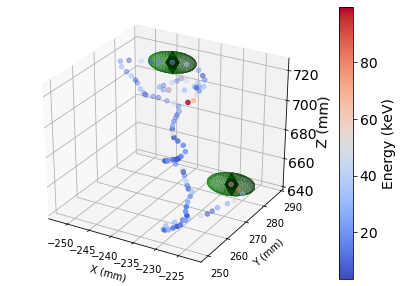

event number in gtEvent list  = 2


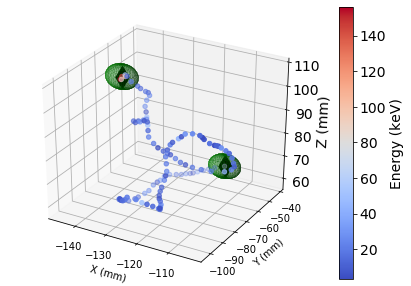

event number in gtEvent list  = 3


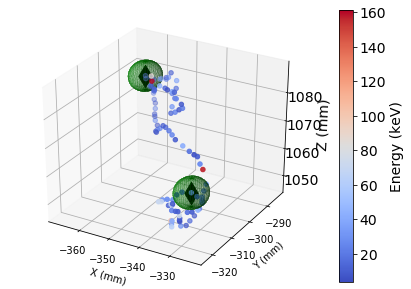

event number in gtEvent list  = 5


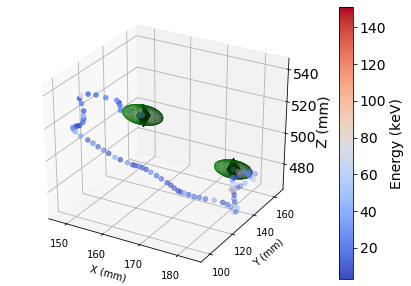

event number in gtEvent list  = 6


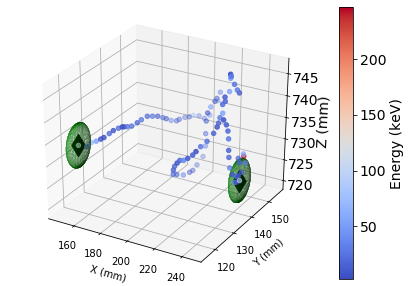

event number in gtEvent list  = 8


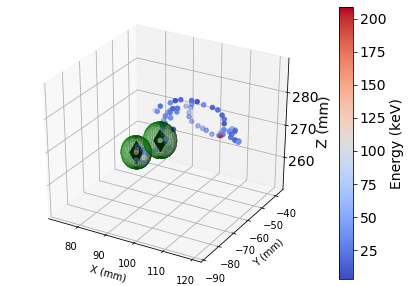

event number in gtEvent list  = 9


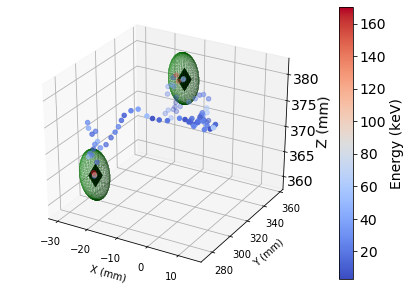

event number in gtEvent list  = 12


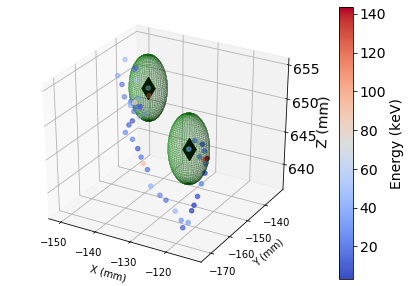

event number in gtEvent list  = 13


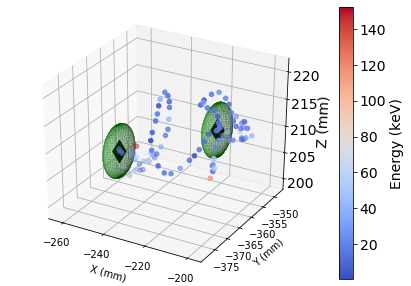

event number in gtEvent list  = 14


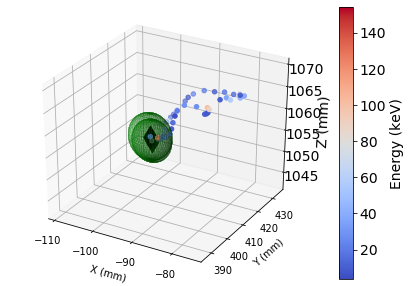

event number in gtEvent list  = 15


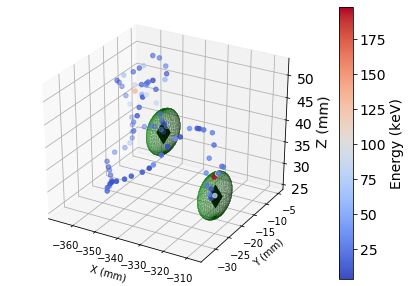

event number in gtEvent list  = 17


In [140]:
plot_single_tracks_list(gtEvent, est, rb = 5, 
                        nplots=10, figsize = (7,5), fontsize=10)

### Display events with multiple tracks

In [130]:
Verbose = False
if Verbose:
    print(f'\n events multiple track (ems) = {emt}')

event number in gtEvent list  = 0


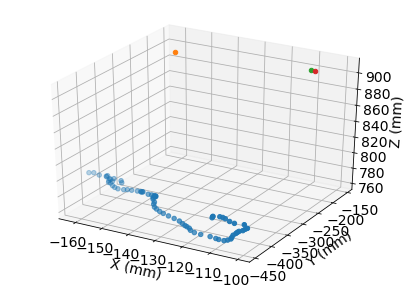

event number in gtEvent list  = 4


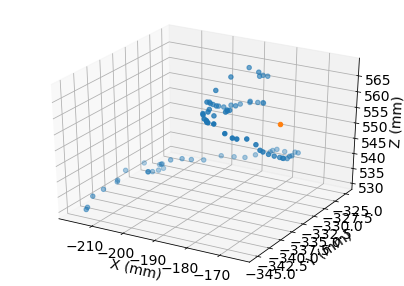

event number in gtEvent list  = 7


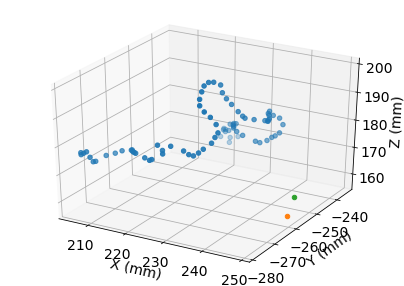

event number in gtEvent list  = 10


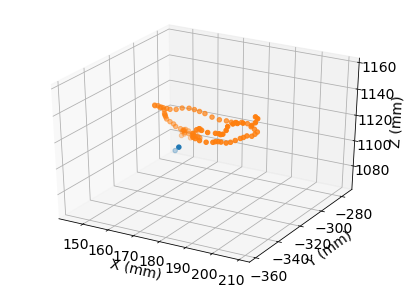

event number in gtEvent list  = 11


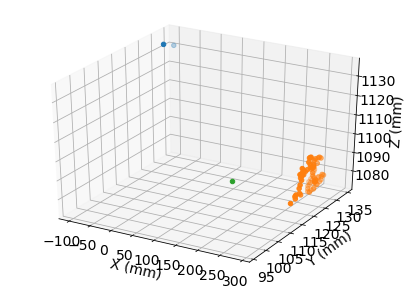

event number in gtEvent list  = 16


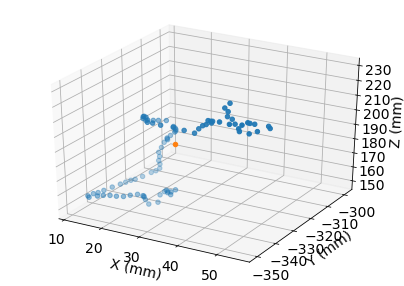

event number in gtEvent list  = 18


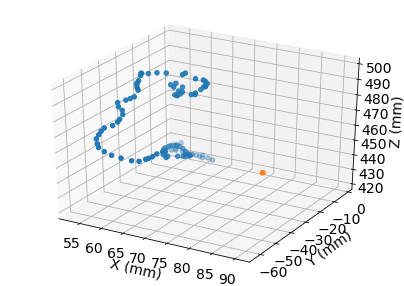

event number in gtEvent list  = 20


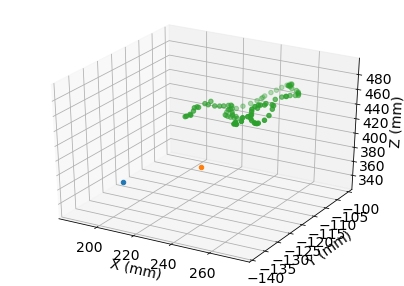

event number in gtEvent list  = 22


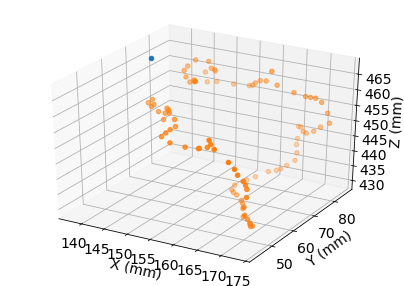

event number in gtEvent list  = 23


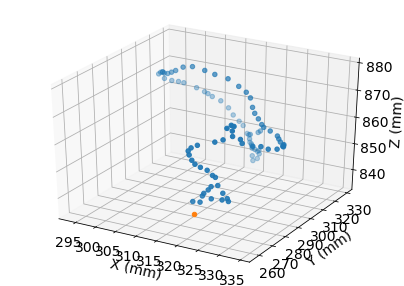

event number in gtEvent list  = 26


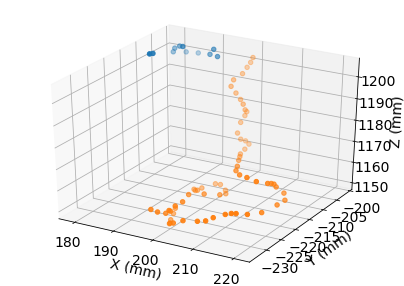

In [143]:
plot_multiple_tracks_list(gtEvent, emt, nplots=10, figsize = (7,5), fontsize=10)